# The effect of Acoustic Model training
In this notebook we evaluate the effect of `Acoustic Model training`. We walk you through the process of comparing a baseline pre-trained acoustic model with an acoustic model finetuned on domain specific data.

1. We first train an acoustic model on a domain specific dataset. More specifically, we finetune a pre-trained baseline model, where we perform knowledge transfer from a [model trained on LibriSpeech with EN Common Voice](https://ngc.nvidia.com/catalog/models/nvidia:quartznet15x5) and train it with new a domain specific dataset.

2. We compare the performance of the baseline model and the fine-tuned model by performing inference with both models and compare their WER performance. 

To simplify and enable reproducibility of the ASR workflow, this application allows you to create a `project` which enables the tracking of datasets, models and configurations across all workflows – i.e. acoustic model and language model pipelines.

In [1]:
import os 
import sys

os.environ['APP_DIR']='..'
os.environ['DATA_DIR']=os.path.join(os.environ['APP_DIR'],'data')
sys.path.append(os.environ['APP_DIR'])
PROJECT_ROOT = os.path.abspath(os.path.join('..', os.path.dirname(os.path.dirname('.'))))

In [2]:
PROJECT_ROOT

'/home/ubuntu/gong/nemo_asr_app_1'

In [4]:
import torch

print ("GPU is enabled:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU count:", torch.cuda.device_count())
    print("Device name:", torch.cuda.get_device_name(0))



GPU is enabled: True
GPU count: 1
Device name: Tesla V100-SXM2-16GB


In [70]:
# required imports
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from easydict import EasyDict as edict
import torchaudio
import glob
import os
import subprocess
import tarfile
import wget
import requests
import urllib.request
from tqdm import tqdm
import json
import soundfile as sf
import librosa
import librosa.display
import re
from pathlib import Path
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd


from tools.System.config import cfg
from tools.System.reader import Reader
from tools.misc import parse_manifest_wer, barplot_manifest, get_transcript, get_gtruth


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Create a new project

We create a project that will keep track of the datasets, configurations and models created across the acoustic model and language model workflows.
Everything related to a project is saved in disc in a manifest that can be access through its `project_id`.

At the start of the project, the manifest is pre-populated with the baseline pretrained models. For acoustic model we use a pretrained model on LibriSpeech with a greedy decoder and for language model we use a Baidu's CTC decoder model. Both pre-trained models were built or downloaded in `Step 0` and thus exist in the `example_data` folder.

# Get data

In [23]:
ENDPOINT = 'http://www.openslr.org/resources/7/'
DATA_PREFIX = 'TEDLIUM'
DATASET_NAME = f"{DATA_PREFIX}_release1.tar.gz"


class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

DATA_DIR = os.path.join(PROJECT_ROOT,'data')
current_datasets_dir = os.path.join(DATA_DIR,DATA_PREFIX)
dataset_path = os.path.join(current_datasets_dir,DATASET_NAME)

print('Dataset path:', dataset_path)

if not os.path.exists(dataset_path):
    print(f"Downloading {DATASET_NAME}: {ENDPOINT+DATASET_NAME}")
    
    if not os.path.exists(current_datasets_dir):
        os.mkdir(current_datasets_dir)
    
    download_url(ENDPOINT+DATASET_NAME, dataset_path)
    
else:
    print("Tarfile already exists.")
    
if not os.path.exists(dataset_path[:-7]):
    print("Decompressing data")
    tar = tarfile.open(dataset_path)
    tar.extractall(current_datasets_dir)
else:
    print("Tarfile has been already decompressed")

Dataset path: /home/ubuntu/gong/nemo_domain_specific/data/TEDLIUM/TEDLIUM_release1.tar.gz
Tarfile already exists.
Tarfile has been already decompressed


# Build manifest

### librispeech manifest

In [26]:
# Librispeech manifest

def libri_speech_chapter_build_manifest(transcripts_path, manifest_path, flac_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                transcript = ' '.join(line.split(' ')[1:]).lower()
                file_id = line.split(' ')[0]
                audio_path = os.path.join(
                     flac_path,
                     file_id + '.flac')
                y, sr = sf.read(audio_path)
                duration = librosa.get_duration(y=y, sr=sr)

                # Write the metadata to the manifest
                metadata = {
                     "audio_filepath": audio_path,
                     "duration": duration,
                     "text": transcript
                }
                
                json.dump(metadata, fout)
                fout.write('\n')


TRAIN_DATA_DIR = Path(os.path.join(current_datasets_dir,'LibriSpeech/train-clean-100'))
train_texts = list(TRAIN_DATA_DIR.glob('**/*.trans.txt'))
train_audios = list(TRAIN_DATA_DIR.glob('**/*.flac'))

def generate_manifest(_path, list_of_train_texts):
    for the_train_transcripts in list_of_train_texts:
        libri_speech_chapter_build_manifest(the_train_transcripts , _path, the_train_transcripts.parent)

train_manifest_path = os.path.join(current_datasets_dir, 'train_manifest.json')
test_manifest_path = os.path.join(current_datasets_dir, 'test_manifest.json')


generate_manifest(_path=train_manifest_path,list_of_train_texts=train_texts[:40])
generate_manifest(_path=test_manifest_path,list_of_train_texts=train_texts[40:50])

### abstract manifest

In [ ]:
def build_abstract_manifest(manifest_path, audio_files: list, transcripts: list):
    """
    audio_files: list of paths to audios, 
    transcripts: list of strings of the same length as audio_files
    """
    
    with open(manifest_path, 'w') as fout
        for audio_path, transcript in zip(audio_files, transcripts)
        y, sr = sf.read(audio_path)
        duration = librosa.get_duration(y=y, sr=sr)

        current_line = {
             "audio_filepath": audio_path,
             "duration": duration,
             "text": transcript
        }

        json.dump(metadata, fout)
        fout.write('\n')

### transform data

In [99]:
from abc import ABC, abstractmethod
from tools.sph2wav import SPHFile

class AbstractDataTransformer(ABC):

    @abstractmethod
    def get_audio_and_transcrpits(self, path, *args, **kwargs):
        pass

class TedliumDataTransformer(AbstractDataTransformer):
    
    
    def __init__(self, sample_rate):
        self.sample_rate: int = sample_rate
    
    def get_audio_and_transcrpits(self, path):
        
        transformed_audio_path = os.path.join(path, 'transformed_audio')
        
        if not os.path.exists(transformed_audio_path):
            os.mkdir(transformed_audio_path)
                
        transformed_data = list()
        
        audio_dir = os.path.join(path,'sph')
        transripts_dir = os.path.join(path,'stm')
        
        for audio_path, transcript_path in zip(os.listdir(audio_dir),
                                  os.listdir(transripts_dir)):
            
            sph_audio = SPHFile(os.path.join(audio_dir, audio_path)).open()
            text_segments = self.get_segments_from_transcript(os.path.join(transripts_dir,transcript_path))
            audio_segments = self.get_audio_segments(os.path.join(audio_dir,audio_path), text_segments)
            
            for idx, audio_segment in enumerate(audio_segments):
                audio_segment_path = os.path.join(transformed_audio_path, audio_path[:-4])
                if not os.path.exists(audio_segment_path):
                    os.mkdir(audio_segment_path)
                audio_segment_chunk_path = os.path.join(audio_segment_path, f'{str(idx)}.wav')

                sph_audio.write_wav(audio_segment_chunk_path, audio_segment['start'], audio_segment['end'])
                transformed_data.append({'transcript':audio_segment['transcript'],
                                         'audio':audio_segment_chunk_path})
        return transformed_data
            
            
    def get_segments_from_transcript(self, transcript_path):
        with open(transcript_path) as transcript_fd:
            transcripts = transcript_fd.read()
            segments = [ent for ent in transcripts.split('\n') 
                        if '' != ent]
        return segments

    def get_audio_segments(self, audio_path, text_segments):
        _segments = list()
        for idx, segment in enumerate(text_segments):
            the_md, the_transcript = re.split(r' <.+> ',segment)
            if the_transcript.strip() == 'ignore_time_segment_in_scoring':
                continue
            left_timestamp, right_timestamp = map(float,the_md.split(' ')[-2:])
            left_idx = left_timestamp
            right_idx = right_timestamp
            _segments.append({'audio_path':audio_path,
                              'start': left_idx,
                              'end': right_idx,
                              'transcript':the_transcript})
        return _segments
    

In [100]:
tedlium_transformer = TedliumDataTransformer(sample_rate=16)
tedlium_dev_dataset_path = os.path.join(dataset_path[:-7], 'dev')
data = tedlium_transformer.get_audio_and_transcrpits(path=tedlium_dev_dataset_path)

# Visualize example

last year i showed these two slides so that demonstrate that the arctic ice cap which for most of the last three million years has been the size of the lower forty eight states has shrunk by forty percent


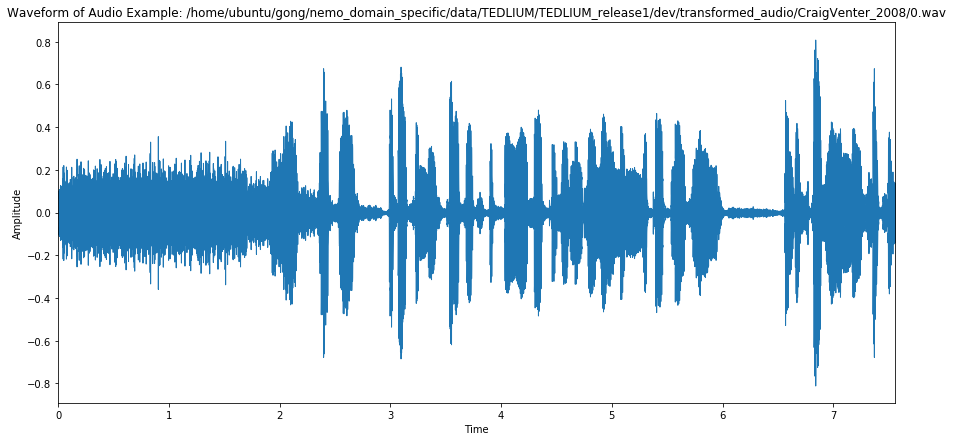

In [103]:
def visualize_audio(path_to_audio):
    audio, sample_rate = sf.read(path_to_audio)

    plt.rcParams['figure.figsize'] = (15,7)
    plt.title(f'Waveform of Audio Example: {path_to_audio}')
    plt.ylabel('Amplitude')

    _ = librosa.display.waveplot(audio)
    
    return audio, sample_rate

example_transcript = data[0]['transcript']
example_audio = data[0]['audio']

audio, sample_rate = visualize_audio(example_audio)
print(example_transcript)

In [104]:
ipd.Audio(audio, rate=sample_rate)

# Fine tuning

In [27]:
class FineTuningExecutor:
    
    def __init__(self):
        
        self.experiment_name: str = None
        
        #train manifest and working directory for logs
        self.train_manifest_path: str = None            
        self.workdir: str = None
        
        self.jasper_train_script_path: str = None
            
        #paths to external configs   
        self.model_architecture_path: str = None
        self.pretrained_encoder_path: str = None
        self.pretrained_decoder_path: str = None
        
        #params
        self.batch_size: int = None
        self.num_epochs: int = None
        self.learning_rate: float = None        
        self.optimizer: str = None
        
        self.nproc_per_node: int = None
        self.amp_opt_level: str = None
        
    def generate_train_command(self):
        command = f"""!python3 -m torch.distributed.launch 
                    --nproc_per_node={self.nproc_per_node} {self.jasper_train_script_path} 
                    --batch_size={self.batch_size}
                    --num_epochs={self.num_epochs}
                    --lr={self.learning_rate} 
                    --model_config={self.model_architecture_path}  
                    --optimizer={self.optimizer}
                    --amp_opt_level={self.amp_opt_level}
                    --finetune 
                    --load_encoder={self.pretrained_encoder_path} 
                    --load_decoder={self.pretrained_decoder_path}  
                    --work_dir={self.workdir} 
                    --exp_name={self.experiment_name} 
                    --train_dataset={self.train_manifest_path} 
                  """
        command = command.replace('\n',' ').strip()
        command = re.sub(r'\s{2,}',r' ',command)
        return command

    def __str__(self):
        return f"FineTuningExedcutor for experiment {self.experiment_name}"
    
    
finetuner = FineTuningExecutor()
finetuner.experiment_name = DATA_PREFIX
finetuner.train_manifest_path = os.path.join(current_datasets_dir, train_manifest_path)
finetuner.workdir = os.path.join(DATA_DIR,f'model_{DATA_PREFIX}')
finetuner.jasper_train_script_path = os.path.join(PROJECT_ROOT,'tools/NeMo/jasper_train.py')
finetuner.model_architecture_path = os.path.join(PROJECT_ROOT,'demo/quartznet15x5/quartznet15x5.yaml')
finetuner.pretrained_encoder_path = os.path.join(PROJECT_ROOT,'demo/quartznet15x5/JasperEncoder-STEP-247400.pt')
finetuner.pretrained_decoder_path = os.path.join(PROJECT_ROOT,'demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt')
finetuner.batch_size = 16
finetuner.num_epochs=5
finetuner.learning_rate=0.0001
finetuner.optimizer='novograd'
finetuner.amp_opt_level='O1'
finetuner.nproc_per_node=torch.cuda.device_count()

finetuner.generate_train_command()

'!python3 -m torch.distributed.launch --nproc_per_node=1 /home/ubuntu/gong/nemo_domain_specific/tools/NeMo/jasper_train.py --batch_size=16 --num_epochs=5 --lr=0.0001 --model_config=/home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/quartznet15x5.yaml --optimizer=novograd --amp_opt_level=O1 --finetune --load_encoder=/home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/JasperEncoder-STEP-247400.pt --load_decoder=/home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt --work_dir=/home/ubuntu/gong/nemo_domain_specific/data/model_TEDLIUM --exp_name=TEDLIUM --train_dataset=/home/ubuntu/gong/nemo_domain_specific/data/TEDLIUM/train_manifest.json'

In [16]:
!python3 -m torch.distributed.launch --nproc_per_node=1 /home/ubuntu/gong/nemo_domain_specific/tools/NeMo/jasper_train.py --batch_size=16 --num_epochs=5 --lr=0.0001 --model_config=/home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/quartznet15x5.yaml --optimizer=novograd --amp_opt_level=O1 --finetune --load_encoder=/home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/JasperEncoder-STEP-247400.pt --load_decoder=/home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt --work_dir=/home/ubuntu/gong/nemo_domain_specific/data/model_librispeech --exp_name=librispeech --train_dataset=/home/ubuntu/gong/nemo_domain_specific/data/librispeech/train_manifest.json

GPU count 1
2020-04-08 09:34:12,644 - INFO - Doing ALL GPU
2020-04-08 09:34:12,805 - INFO - Dataset loaded with 0.09 hours. Filtered 0.00 hours.
2020-04-08 09:34:12,805 - INFO - Parallelizing DATALAYER
2020-04-08 09:34:12,805 - INFO - Have 27 examples to train on.
2020-04-08 09:34:12,811 - INFO - PADDING: 16
2020-04-08 09:34:12,811 - INFO - STFT using conv
2020-04-08 09:34:13,103 - INFO - There were no val datasets passed
2020-04-08 09:34:13,697 - INFO - Finetuning
2020-04-08 09:34:14,390 - INFO - Loaded encoder: /home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/JasperEncoder-STEP-247400.pt
2020-04-08 09:34:14,393 - INFO - Loaded decoder: /home/ubuntu/gong/nemo_domain_specific/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt
2020-04-08 09:34:14,393 - INFO - ================================
2020-04-08 09:34:14,395 - INFO - Number of parameters in encoder: 18894656
2020-04-08 09:34:14,395 - INFO - Number of parameters in decoder: 29725
2020-04-08 09:34:14,396 - INFO - Total 

# 2. Fine-tune Pretrained Acoustic Model with `Domain Specific` Data
Next, we finetune a baseline model with our own data.

The steps are: 
1. Add pre-processed dataset to project
2. Adjust training parameters
3. Generate training command
4. Perform Training 

Note, if the WSJ is not available to you, you can alternatively walk through these 4 steps using a dummy dataset but in the process the system will generate the correct directories. 
Then you can replace the checkpoints with the checkpoints of the **fine-tuned WSJ model** used to generate the results below, available in NGC in this [link](https://ngc.nvidia.com/models/nvidia:wsj_quartznet_15x5) 
You will place these checkpoints in the following directory:
`[data_dir]/models/acoustic_models/WSJ/WSJ_finetuning-lr_0.0001-bs_16-e_100-wd_0.0-opt_novograd/checkpoints/`

## 2.1. Add Training Datasets to the Project 
To train an acoustic model you require a pre-processed `json` training dataset.
NeMo expects the dataset as a `json` file where each entry has the keys: `audio_filepath`, `duration` and `text`.

Note: Make sure the pre-processed dataset has the correct paths to the audio files.

In [ ]:
# train dataset
train_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj", "wsj-train-si284-speed-0.9-1.1.json")

project.add_dataset(train_json, "WSJ-wsj-train-speed", dataset_type="am-train")
project.manifest.am

## 2.2 Modify acoustic model training parameters
The default training parameters are specified in the project manifest, training script and the configuration file  `[DATA_DIR]/config_files/[Project_id]_acoustic_quartznet15x5.yaml`. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.am.train_params`, to see other parameters look at the NeMo training script at `/tools/NeMo/jasper_train.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).
- To enable finetuning you must set the parameter `finetuning` to "True" and set the path to the `pre-trained encoder and decoder` to the parameters `load_encoder` and `load_decoder` respectively. Note, the finetuning and pre-trained encoder and decoders are already added at the start of the project.

In [ ]:
project.set_am_batch_size(16)
project.set_am_num_gpus(4)
project.set_am_learning_rate(0.0001)
project.manifest.am.train_params.warmup_steps = 0 
#project.manifest.am.train_params.weight_decay = 0.0001

# If your dataset has 200+ Hrs of audio you can fine-tune for less epochs, e.g. 100.
project.set_am_num_epochs(100)

# novograd
#project.manifest.am.train_params.beta1 = 0.95
#project.manifest.am.train_params.beta2 = 0.25 

# To modify the path to config file and the pretrained model
#project.load_am_config_file(config_file='')
#project.set_am_pretrained_model(model='')

project.save_manifest()
project.manifest.am

## 2.3 Generate Training Command
Next we generate the acoustic training command, we use the settings specified in the manifest to create the appropriate command.

In [ ]:
am_training_cmd = project.get_am_train_cmd()
print("! "+ am_training_cmd)

## 2.4. Fine-tune Pretrained Model
Now that we have the training command that reflects the project configuration, we can perform acoustic model training. Note, acoustic model training can take a long time so it is be better to run training directly from the terminal of the container, using the command generated.

Note, if you completed the training before, you'll have checkpoints saved in the working directory.  We'll need to remove these to restart training. 

In [ ]:
# clean log directory to re-run the training command
#project.clean_am_workdir()

Copy (select cmd + shift RMB + copy) the command generated and paste it below to run training inside the notebook, we recommend you run it at the container's terminal.

In [ ]:
#! python -m torch.distributed.launch --nproc_per_node=4 /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_train.py --batch_size=16 --num_epochs=100 --lr=0.0001 --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --optimizer=novograd --amp_opt_level=O1 --finetune --load_encoder=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperEncoder-STEP-247400.pt --load_decoder=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt --work_dir=/raid/datasets/asr/data/models/acoustic_models/WSJ --exp_name=WSJ_finetuning --train_dataset=/raid/datasets/asr/data/example_data/wsj/wsj-train-si284-speed-0.9-1.1.json

# 3. Inference with Pre-trained and Fine-tuned Models
Next, we perform inference with both the pre-trained and fine-tuned models.

The steps are: 
1. Add pre-processed evaluation datasets to project
2. Inference with Pre-trained model
3. Inference with Fine-tuned model

## 3.1. Add Inference Evaluation Datasets to the Project 
To perform inference you require a preprocessed `json` dataset, with the columns: `audio_filepath`, `duration` and `text`.

In [ ]:
# add inference dataset
eval_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj","wsj-eval-92.json")
#eval_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj","wsj-dev-93.json")

project.add_dataset(eval_json, "wsj-eval", dataset_type="eval")

print(project.manifest.eval_dataset_names)
print(project.manifest.eval_datasets)

## 3.2 Inference with Pre-trained model
To do inference, we follow 3 steps: 1) Adjust inference parameters. 2) Generate inference command 3) Perform inference

### 3.2.1 Modify inference parameters
The default inference parameters are specified in the project manifest, inference script and the configuration file. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.inference_params`, to see other parameters look at the NeMo inference script at `/tools/NeMo/jasper_eval.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).

- When `lm_path` is set to "None", the system will use a `greedy decoder`, and thus the language model parametrs, e.g. `beam_width`, `alpha`, `beta` will not be used.

In [ ]:
project.manifest.inference_params.batch_size = 32
project.manifest.inference_params.amp_opt_level = 'O0'

project.save_manifest()
project.manifest.inference_params

### 3.2.2 Generate Inference Command: Pre-trained Model
We generate the inference command using the manifest configurations.

In [ ]:
# Model Id - We use this to identify the results of this model
model_id = "am-pretrained-greedy-decoder"

# Inference with Pre-trained model
am_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ am_infer_cmd)

### 3.2.3 Run Inference with Pre-trained Model
To run inference, copy (select cmd + shift RMB + copy) the command generated above and paste below.

In [ ]:
! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5 --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O0 --save_results=/raid/datasets/asr/data/inferences/WSJ --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-pretrained-greedy-decoder

## 3.2 Inference with Finetuned model
To do inference with our finetuned model, we have to modify the manifest parameters to point to our finetuned model, then follow the same process as before.

### 3.3.1 Modify inference parameters
The default inference parameters are specified in the project manifest, inference script and the configuration file. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.inference_params`, to see other parameters look at the NeMo inference script at `/tools/NeMo/jasper_eval.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).

- When `lm_path` is set to "None", the system will use a `greedy decoder`, and thus the language model parametrs, e.g. `beam_width`, `alpha`, `beta` will not be used.


Next, you **must** modify the `project.manifest.inference_params.load_dir` to use a different model than the default pretrained model.

- The path to the finetuned model can be found at `project.manifest.am.finetuned_model_path`

In [ ]:
# Path to the finetuned model
project.manifest.am.finetuned_model_path

In [ ]:
# Inference with Fintuned model
# We provide the finetuned model inside the demo folder, but if you trained the model the path is available in project.manifest.am.finetuned_model_path
project.manifest.inference_params.load_dir = os.path.join(os.environ['APP_DIR'], 'demo', 'finetuned') 
project.save_manifest()
project.manifest.inference_params

### 3.3.2 Generate Inference Command
We generate the inference command using the manifest configurations.

In [ ]:
# Model Id - We use this to identify the results of this model
model_id = "am-finetuned-WSJ_train_speed-greedy-decoder"

# Inference with Pretrained model
am_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ am_infer_cmd)

### 3.3.3 Run Inference with Fine-tuned Model
To run inference, copy (select cmd + shift RMB + copy) the command generated above and paste below.

In [ ]:
! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O0 --save_results=/raid/datasets/asr/data/inferences/WSJ --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-finetuned-WSJ_train_speed-greedy-decoder

# 4. Results and Model Comparison

## 4.1 Add Inference results to manifest
We first add the results from our inference runs to the project's manifest.

In [ ]:
project.add_inference_results()

Now that the inference results are added, we can see them in the manifest. 
The results are structured as follows: For each evaluation dataset, we have a multiple models identified by their `model_id` and inside those we have the model's results.

In [ ]:
inf_datasets = list(project.manifest.inference.keys())
print("Datasets with inference: ", inf_datasets)

for inf in inf_datasets:
    print()
    print(inf)
    print(project.manifest.inference[inf])

To obtain the `Transcript` and `Ground Truth` from an evaluation dataset, you can use the commands `get_transcript` and `get_gtruth` using the path to the inference results which can be obtained by `project.get_inf_path`.

In [ ]:
# to get the path to the inference results - you need the dataset path and the model-id you wish to retrieve
path = project.get_inf_path('/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json',
                            'am-finetuned-WSJ_train_speed-greedy-decoder')
print(path)
# get transcript and ground truth
transcript = get_transcript(path)
gtruth = get_gtruth(path)
print(transcript)

## 4.2 Model Comparison
Next, we compare the Word Error Rates for both the fine-tuned model and pre-trained model.

In [ ]:
inferences_all = list(project.manifest.inference.keys())
inferences_all.sort()
print(inferences_all)

We select a eval dataset to plot its performance and we also select the performance metric we wish to sort by.

In [ ]:
sel_inference = project.manifest.inference[inferences_all[0]]
sort_metric = 'percentWER'

# Note if you wish to plot (and parse) only a specific set of models you can use the argument 'keep' and 
# list the model_id(s) you wish to keep.
am_df = parse_manifest_wer(sel_inference, sort_metric=sort_metric, keep=['am-finetuned-WSJ_train_speed-greedy-decoder',
                                                                         'am-pretrained-greedy-decoder'])
print(inferences_all[0])
am_df

We use the dataframe created by the `parse_manifest_wer` function to plot the performance of the different models.
We use the function `barplot_manifest` that has the arguments `([dataframe],[metric to plot],[title],[xlabel],[ylabel])`.

Note:
WER percent may be above 100% when the number of words in the prediction is larger than the number of words in the reference.

In [ ]:
%matplotlib inline
am_wer = barplot_manifest(am_df,'percentWER',"WSJ - Acoustic Model - Word Error Rate", "Inference type","Percent %")

## 5. WER effect of Acoustic training
As shown in the plot, finetuning the acoustic model on our domain data can greatly improve model performance.

In [ ]:
am_df.set_index('inference_types', inplace=True)

In [ ]:
org = am_df.loc['am-pretrained-greedy-decoder','wer'] # pre-trained model
new = am_df.loc['am-finetuned-WSJ_train_speed-greedy-decoder','wer'] # fine-tuned model

In [ ]:
per_decrease = 100*((org-new)/org)
print("Decreased WER by {0:.2f}%".format(per_decrease))